<a id='top'></a>

# Modelo de Aprendizado de Máquina

# Ana Carolina Chebel Pelissari

# <font color='blue'>Importação das bibliotecas necessárias</font>

In [1]:
%matplotlib inline
#import sys
#print(sys.base_prefix) 
#/opt/anaconda3/bin/pip install <package>


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
import math
import seaborn as sns

from termcolor import colored
from datetime import datetime
from numpy import interp
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, classification_report, precision_recall_curve

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from statsmodels.stats.contingency_tables import mcnemar

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# <font color='blue'>Criação das funções</font>

In [5]:
def evaluate_model(model, X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.DataFrame, y_test: pd.DataFrame):
    """
    Used to evaluate a given model. Just an API wrapper.    
    Returns the fitted model along with the predictions generated for the test set
    """
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    y_preds_proba = model.predict_proba(X_test)
    return model, y_preds, y_preds_proba

In [6]:
def generate_performance_stats(y_test, y_pred): 
    target_names = ['Vivo', 'Morto'] 
    cm = confusion_matrix(y_test, y_pred)        
    print("Acurácia: {}\n".format(metrics.accuracy_score(y_test,y_pred)))
    print("Matriz de confusão: \n{}\n".format(pd.crosstab(y_test, y_pred, rownames=['Atual'], colnames=['Previsto'])))
    print("Relatório da Classificação: \n{}\n".format(classification_report(y_test, y_pred, target_names=target_names)))

In [8]:
def perform_cv(df: pd.DataFrame, models, use_oversampling):
        
    results = []
    mean_fpr = np.linspace(0, 1, 100)
    models_predictions = {}

    for model_alias in models:
    
        print("Modelo: {}\n".format(model_alias))
        y_preds = []
        y_probs = []
        y_tests = []
        tprs = []
        aucs = []
        thresholds = []
        model = models[model_alias]

        i = 0
        kf = KFold(n_splits=n_folds, random_state=13, shuffle=True)
        model_predicted = []
        model_gt = []
    
        for index in kf.split(df):

            print("Fold[{}]\n".format(i+1))

            X_train, X_test = df.iloc[index[0]], df.iloc[index[1]]
            
            if use_oversampling:
                X_train = create_balanced_dataset(X_train, 1.0)
            
            train_class_0, train_class_1 = X_train['morte_menor_28d'].value_counts()            
            y_train = X_train['morte_menor_28d']
            X_train = X_train.drop(['id','morte_menor_28d'], axis = 1)
            
            test_class_0, test_class_1 = X_test['morte_menor_28d'].value_counts()            
            y_test = X_test['morte_menor_28d']
            X_test = X_test.drop(['id','morte_menor_28d'], axis = 1)
            
            model_fit, y_pred, y_pred_proba = evaluate_model(model, X_train, X_test, y_train, y_test)
            
            y_pred = y_pred_proba[:,1] > thresh
            y_pred = y_pred.astype(int)  
            model_predicted = np.concatenate((np.array(model_predicted),y_pred))
            model_gt = np.concatenate((np.array(model_gt),y_test))

            fpr, tpr, threshold = roc_curve(y_test, y_pred_proba[:,1])
            prec, rec, tre = precision_recall_curve(y_test, y_pred_proba[:,1])
            
            y_preds = np.append(y_preds, y_pred)
            y_probs = np.append(y_probs, y_pred_proba[:,1])
            y_tests = np.append(y_tests, y_test)        
            
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            thresholds.append(threshold)
            i = i + 1
    
        generate_performance_stats(model_gt, model_predicted)

        result = RESULT(model_alias, y_preds, y_probs, y_tests, tprs, aucs, thresholds)
        results.append(result)
        models_predictions[model_alias] = (model_predicted,model_gt)
        print("########################################################\n")
    
    return results, models_predictions

In [9]:
def plot_roc_curve(results, file_name):
        
    plt.figure(figsize=(10,8))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    i = 0
    
    colors = ['r','b','g']
    
    for idx,result in enumerate(results):
    
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
        mean_tpr = np.mean(result.tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(result.aucs)
        
        plt.plot(mean_fpr, mean_tpr, color=colors[idx], label=result.model_name + ' (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc), lw=2, alpha=.8)
        
        std_tpr = np.std(result.tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        
        if i == 0:
            plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[idx], alpha=.2)
        else:
            plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[idx], alpha=.2)
        i = i + 1
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Chance', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR', size=12)
    plt.ylabel('TPR', size=12)
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    
    dst = "../out/"
    if os.path.isdir(dst) == False:
        os.makedirs(dst)
    dst = dst + "/" + file_name + ".pdf"
    plt.savefig(dst, bbox_inches = 'tight')
    
    plt.show()

In [10]:
def plot_roc_curve_model(y_pred, y_test, y_pred_proba, file_name, model_name, roccolor='red'):
    
    plt.figure(figsize=(10,8))

    # Compute ROC curve and area the curve
    fpr, tpr, threshold = roc_curve(y_test, y_pred_proba[:,1])
    prec, rec, tre = precision_recall_curve(y_test, y_pred_proba[:,1])

    mean_fpr = np.linspace(0, 1, 100)
    
    tprs = []
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0    

    auc = metrics.roc_auc_score(y_test, y_pred_proba[:,1])
    
    plt.plot(mean_fpr, mean_tpr, color=roccolor, label= model_name + ' (AUC = %0.3f)' % (auc), lw=5, alpha=.8)    
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Chance', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR', size=12)
    plt.ylabel('TPR', size=12)
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    
    dst = "../out/"
    if os.path.isdir(dst) == False:
        os.makedirs(dst)
    dst = dst + "/" + file_name + ".pdf"
    plt.savefig(dst, bbox_inches = 'tight')
    
    plt.show()

In [11]:
def plot_myshap(importance_df,shap_sum):
    
    total = 0
    x = np.zeros(26)
    y = range(26)
    y_tmp = []
    y_labels = []
    maxx = 0
    for i in range(26):
        tmp = importance_df.iloc[i,0].split("_")
        y_tmp.append(' '.join(tmp[2:]))
        x[25-i] = (importance_df.iloc[i,1]/np.sum(shap_sum))
        if (importance_df.iloc[i,1]/np.sum(shap_sum)) > maxx:
            maxx = float((importance_df.iloc[i,1]/np.sum(shap_sum)))

    for i in range(25,-1,-1):
        y_labels.append(y_tmp[i])


    fig = plt.figure(figsize=(18,14))
    c1 = 'm'
    c2 = 'c'
    my_colors = ''.join(2*[c2] + 2*[c1] + 11*[c2] + [c1] + 6*[c2] + [c1] + [c2] + 2*[c1])

    barlist = plt.barh(y, x, align='center',color=my_colors,edgecolor='black')
#     for i,b in enumerate(barlist):
#         b[i].set_color(colors[i])
        
    plt.yticks(range(26),y_labels,fontsize=14)
    xlabels = []
    for i in np.arange(0,((maxx*100)+1),2):
        tt = str(i) + "%"
        xlabels.append(tt)
    plt.xticks(np.arange(0,maxx,0.02),xlabels)
    plt.xlabel('Porcentagem da importância')
    plt.title('Importância de cada variável no resultado final da classificação')

    plt.savefig('./images/shapvalues.png')

    plt.show()

In [13]:
def plot_confusion_matrix(results, image_name):
        
    sns.set(font_scale = 1.6)
    plt.figure(figsize=(10,8))
    threshold = 0.5
    index = 0
        
    for result in results:
                            
        cm = confusion_matrix(result.y_pred, result.y_test)
        
        labels = ['Vivo', 'Morto']
        ax = plt.subplot(2, 2, index+1)
        sns.set_palette("PuBuGn_d")
        
        #if index == 0 or index == 2:
        #    show_scale = False
        #else:
        #    show_scale = True
            
        sum_0 =  cm.sum(axis=1)[0]
        sum_1 = cm.sum(axis=1)[1]
        
        cm_aux = np.zeros((2,2))

        cm_aux[0][0] = (cm[1][1] / sum_1)
        cm_aux[0][1] = (cm[1][0] / sum_1)
        cm_aux[1][0] = (cm[0][1] / sum_0)
        cm_aux[1][1] = (cm[0][0] / sum_0)
        
        sns.heatmap(cm_aux, annot=True, ax = ax, fmt=".2%", cmap="Blues", cbar=False)
        
        ax.set_title(result.model_name)
        ax.yaxis.set_ticklabels(['Morto', 'Vivo'])
        ax.xaxis.set_ticklabels(['Morto', 'Vivo'])
        
        if index == 0 or index == 1:
            ax.set_xlabel('');
        else:
            ax.set_xlabel('Valores previstos');
            
        if index == 1 or index == 3:
            ax.set_ylabel(''); 
        else:
            ax.set_ylabel('Valores corretos')
            
        index = index + 1
        
    dst = "../out/"
    if os.path.isdir(dst) == False:
        os.makedirs(dst)
    dst = dst + image_name + ".pdf"
    plt.savefig(dst, bbox_inches = 'tight')
    
    plt.show()

In [14]:
class RESULT(object):
    
    def __init__(self, model_name, y_pred, y_prob, y_test, tprs, aucs, thresholds):
        self.model_name = model_name
        self.y_pred = y_pred
        self.y_prob = y_prob        
        self.y_test = y_test
        self.tprs = tprs
        self.aucs = aucs
        self.thresholds = thresholds

In [15]:
colNamesEng = {'id':'id',
            'n_tp_ocorrencia'       :'tp_birth_place', # Local de nascimento: 1 – Hospital; 2 – Outros estabelecimentos de saúde; 3 – Domicílio; 4 – Outros.
            'n_nu_idade'            :'maternal_age',
            'n_tp_estado_civil'     :'tp_marital_status', # Situação conjugal da mãe: 1 - Solteira; 2 - Casada; 3 - Viúva; 4 - Separada judicialmente/divorciada; 5– União estável; 9 - Ignorada.
            'n_tp_escolaridade'     :'tp_maternal_education_years', # Escolaridade, em anos de estudo concluídos: 1 – Nenhuma; 2 - 1 a 3 anos; 3 - 4a7 anos; 4 - 8a11 anos; 5 - 12 e mais; 9 - Ignorado.
            'n_qt_nascidos_vivos'   :'num_live_births',
            'n_qt_nascidos_mortos'  :'num_fetal_losses',
            'n_tp_gestacao'         :'tp_pregnancy_duration', # Semanas de gestação: 1 - Menos de 22 semanas; 2 - 22 a 27 semanas; 3 - 28 a 31 semanas; 4 - 32 a 36 semanas; 5 - 37 a 41 semanas; 6 - 42 semanas e mais; 9– Ignorado
            'n_tp_gravidez'         :'tp_pregnancy', # Tipo de gravidez: 1– Única; 2– Dupla; 3– Tripla ou mais; 9– Ignorado.
            'n_tp_parto'            :'tp_labor', # Tipo de parto: 1– Vaginal; 2– Cesário; 9– Ignorado
            'n_tp_prenatal'         :'num_prenatal_appointments', # Número de consultas de pré‐natal. Valores: 1– Nenhuma; 2– de 1 a 3; 3– de 4 a 6; 4– 7 e mais; 9– Ignorado.
            'n_nu_apgar1'           :'cd_apgar1',
            'n_nu_apgar5'           :'cd_apgar2',
            'n_nu_peso'             :'newborn_weight', # In grams
            'n_st_malformacao'      :'has_congenital_malformation', # Anomalia identificada: 1– Sim; 2– Não; 9– Ignorado
            'n_tp_escolaridade_2010':'tp_maternal_education_level', #Escolaridade 2010. Valores: 0 – Sem escolaridade; 1 – Fundamental I (1a a 4a série); 2 – Fundamental II (5a a 8a série); 3 – Médio (antigo 2o Grau); 4 – Superior incompleto; 5 – Superior completo; 9 – Ignorado.
            'n_tp_raca_cor_mae'     :'tp_maternal_skin_color', # Tipo de raça e cor da mãe: 1 - Branca; 2 - Preta; 3 - Amarela; 4 - Parda; 5 Indígena.
            'n_qt_gestacao_anterior':'num_gestations',
            'n_qt_parto_normal'     :'num_normal_labors',
            'n_qt_parto_cesarea'    :'num_cesarean_labors',
            'n_nu_semana_gestacao'  :'num_gestational_weeks', # Número de semanas de gestação.
            'n_tp_apresentacao'     :'tp_presentation_newborn', # Tipo de apresentação do RN. Valores: 1– Cefálico; 2– Pélvica ou podálica; 3– Transversa; 9– Ignorado.
            'n_tp_nascimento_assistido':'tp_childbirth_assistance', # Nascimento foi assistido por? Valores: 1 - Médico; 2 - Enfermeira/obstetriz; 3 - Parteira; 4 - Outros; 9 - Ignorado.
            'n_tp_funcao_responsavel':'tp_fill_form_responsible', #  Tipo de função do responsável pelo preenchimento. Valores: 1– Médico; 2– Enfermeiro; 3– Parteira; 4– Funcionário do cartório; 5– Outros.
            'n_tp_grupo_robson'     :'robson_group',
            # INFORMAçÂÂO SIMILAR ao CAMPO n_tp_escolaridade_2010, VERIFICAR % de PREENCHIMENTO PARA DECIDIR SE EXCLUIMOS
            'n_tp_escolaridade_agregado1':'WW', # Escolaridade 2010 agregada. Valores: 00 – Sem Escolaridade; 01 – Fundamental I Incompleto; 02 – Fundamental I Completo; 03 – Fundamental II Incompleto; 04 – Fundamental II Completo; 05 – Ensino Médio Incompleto; 06 – Ensino Médio Completo; 07 – Superior Incompleto; 08 – Superior Completo; 09 – Ignorado; 10 – Fundamental I Incompleto ou Inespecífico; 11 – Fundamental II Incompleto ou Inespecífico; 12 – Ensino Médio Incompleto ou Inespecífico.
            # SEM DESCRICAO, VERIFICAR % de PREENCHIMENTO PARA DECIDIR SE EXCLUIMOS
            'n_tp_escolaridade_agregado2':'KK',
            'morte_menor_28d':'YY'}

# <font color='blue'>Importação do arquivo csv como dataframe</font>

Link da Base de dados : https://doi.org/10.7303/syn22240254

In [16]:
path = 'df_neonatal_sao_paulo.csv'
df = pd.read_csv(path,low_memory=False)

In [17]:
print("The dataset has {} many rows and {} columns".format(df.shape[0], df.shape[1]))

The dataset has 1435834 many rows and 25 columns


# <font color='blue'>Criação dos modelos de aprendizado de máquina</font>

### K-Fold Cross Validation - Dataset desbalanceado

In [17]:
models = {
    'XGBoost': XGBClassifier(),
    'RF': RandomForestClassifier(n_estimators=100,criterion='gini'),
    'Logistic': LogisticRegression()
}

In [48]:
#Parâmetros do K-Fold cross validation
thresh = 0.5
n_folds = 5
k_fold_seed = 13

df_train = df.copy()
results_exp1, models_pred_exp1 = perform_cv(df_train, models, False)

Modelo: XGBoost

Fold[1]

Fold[2]

Fold[3]

Fold[4]

Fold[5]

Acurácia: 0.9953490445274314

Matriz de confusão: 
Previsto      0.0   1.0
Atual                  
0.0       1426365  1541
1.0          5137  2791

Relatório da Classificação: 
              precision    recall  f1-score   support

        Vivo       1.00      1.00      1.00   1427906
       Morto       0.64      0.35      0.46      7928

    accuracy                           1.00   1435834
   macro avg       0.82      0.68      0.73   1435834
weighted avg       0.99      1.00      0.99   1435834


########################################################

Modelo: RF

Fold[1]

Fold[2]

Fold[3]

Fold[4]

Fold[5]

Acurácia: 0.9953455622307315

Matriz de confusão: 
Previsto      0.0   1.0
Atual                  
0.0       1426605  1301
1.0          5382  2546

Relatório da Classificação: 
              precision    recall  f1-score   support

        Vivo       1.00      1.00      1.00   1427906
       Morto       0.66      0.3

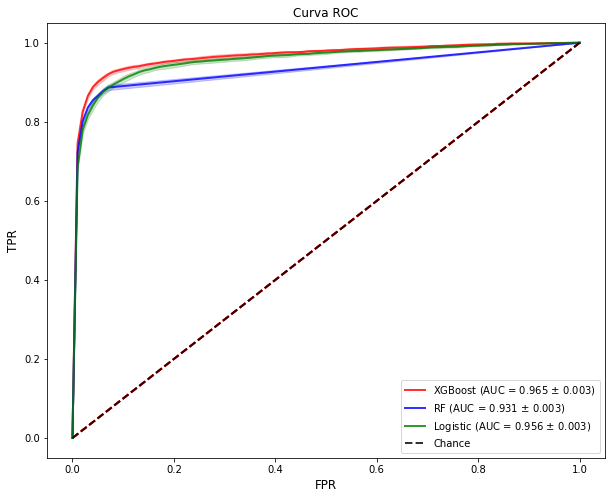

In [49]:
plot_roc_curve(results_exp1, "roc_curve_imbalanced_5kfold")

### Experimento para analisar a curva de precisão/cobertura - Dataset com atribuição de pesos na classe minoritária (Morto)

In [50]:
X_train, X_test = train_test_split(df, test_size=0.30, random_state=13)

y_train = X_train['morte_menor_28d'].values
X_train = X_train.drop(['morte_menor_28d', 'id'], axis=1)

y_test = X_test['morte_menor_28d'].values
X_test = X_test.drop(['morte_menor_28d', 'id'], axis=1)

XGBOOST MODEL

---Peso 1 para a classe Morto ---
Acurácia: 0.9952756929177181

Matriz de confusão: 
Previsto       0    1
Atual                
0         427889  453
1           1582  827

Relatório da Classificação: 
              precision    recall  f1-score   support

        Vivo       1.00      1.00      1.00    428342
       Morto       0.65      0.34      0.45      2409

    accuracy                           1.00    430751
   macro avg       0.82      0.67      0.72    430751
weighted avg       0.99      1.00      0.99    430751


---Peso 10 para a classe Morto ---
Acurácia: 0.9910133696729665

Matriz de confusão: 
Previsto       0     1
Atual                 
0         425212  3130
1            741  1668

Relatório da Classificação: 
              precision    recall  f1-score   support

        Vivo       1.00      0.99      1.00    428342
       Morto       0.35      0.69      0.46      2409

    accuracy                           0.99    430751
   macro avg       0.67      0.84      0.73

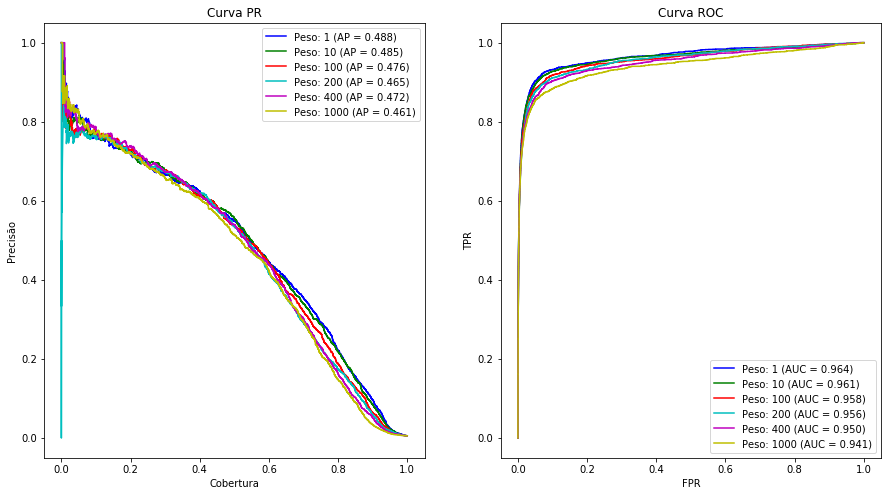

In [52]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Cobertura')
ax1.set_ylabel('Precisão')
ax1.set_title('Curva PR')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('FPR')
ax2.set_ylabel('TPR')
ax2.set_title('Curva ROC')

#[1,10,50,100,1000]
for w,k in zip([1, 10, 100, 200, 400, 1000],'bgrcmykw'):
    
    print('---Peso {} para a classe Morto---'.format(w))
    
    paramsxgb = {'scale_pos_weight': w}
    #paramsxgb = {'scale_pos_weight': w}
    model = XGBClassifier(**paramsxgb)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)    

    p,r,_ = precision_recall_curve(y_test, y_prob[:,1])
    tpr,fpr,_ = roc_curve(y_test, y_prob[:,1])          
    
    auc = metrics.roc_auc_score(y_test, y_prob[:,1])
    average_precision = average_precision_score(y_test, y_prob[:,1])
    
    generate_performance_stats(y_test, y_pred)
    
    ax1.plot(r,p,c=k,label='Peso: ' + str(w) + ' (AP = %0.3f)' % (average_precision))
    ax2.plot(tpr,fpr,c=k,label='Peso: ' + str(w) + ' (AUC = %0.3f)' % (auc))
    
ax1.legend(loc='upper right')    
ax2.legend(loc='lower right')

dst = "../out/"
if os.path.isdir(dst) == False:
    os.makedirs(dst)
dst = dst + "/xgb_prec_rec_roc_curve_imbalanced.pdf"
plt.savefig(dst, bbox_inches = 'tight')

plt.show()

RANDOM FOREST MODEL

---Peso 1 para a classe Morto---
Acurácia: 0.9950876492451556

Matriz de confusão: 
Previsto       0    1
Atual                
0         427932  410
1           1706  703

Relatório da Classificação: 
              precision    recall  f1-score   support

        Vivo       1.00      1.00      1.00    428342
       Morto       0.63      0.29      0.40      2409

    accuracy                           1.00    430751
   macro avg       0.81      0.65      0.70    430751
weighted avg       0.99      1.00      0.99    430751


---Peso 10 para a classe Morto---
Acurácia: 0.9950296110746115

Matriz de confusão: 
Previsto       0    1
Atual                
0         428004  338
1           1803  606

Relatório da Classificação: 
              precision    recall  f1-score   support

        Vivo       1.00      1.00      1.00    428342
       Morto       0.64      0.25      0.36      2409

    accuracy                           1.00    430751
   macro avg       0.82      0.63      0.68    43

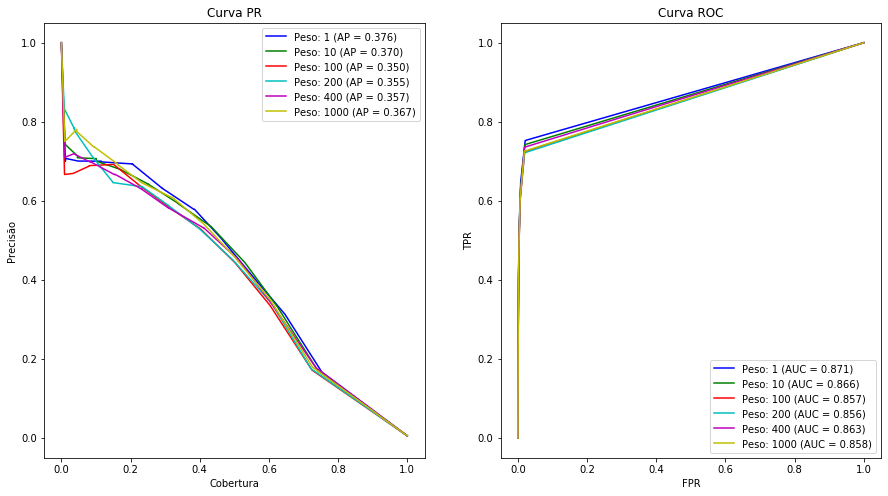

In [53]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Cobertura')
ax1.set_ylabel('Precisão')
ax1.set_title('Curva PR')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('FPR')
ax2.set_ylabel('TPR')
ax2.set_title('Curva ROC')

#[1,10,50,100,1000]
for w,k in zip([1, 10, 100, 200, 400, 1000],'bgrcmykw'):
    
    print('---Peso {} para a classe Morto---'.format(w))
    
    paramsrf = {'class_weight' : {0 : 1, 1 : w}} 
    model = RandomForestClassifier(**paramsrf)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)    

    p,r,_ = precision_recall_curve(y_test, y_prob[:,1])
    tpr,fpr,_ = roc_curve(y_test, y_prob[:,1])          
    
    auc = metrics.roc_auc_score(y_test, y_prob[:,1])
    average_precision = average_precision_score(y_test, y_prob[:,1])
    
    generate_performance_stats(y_test, y_pred)
    
    ax1.plot(r,p,c=k,label='Peso: ' + str(w) + ' (AP = %0.3f)' % (average_precision))
    ax2.plot(tpr,fpr,c=k,label='Peso: ' + str(w) + ' (AUC = %0.3f)' % (auc))
    
ax1.legend(loc='upper right')    
ax2.legend(loc='lower right')

dst = "../out/"
if os.path.isdir(dst) == False:
    os.makedirs(dst)
dst = dst + "/rf_prec_rec_roc_curve_imbalanced.pdf"
plt.savefig(dst, bbox_inches = 'tight')

plt.show()

LOGISTIC REGRESSION MODEL

---Peso 1 para a classe Morto---
Acurácia: 0.9949042486262365

Matriz de confusão: 
Previsto       0    1
Atual                
0         427974  368
1           1827  582

Relatório da Classificação: 
              precision    recall  f1-score   support

        Vivo       1.00      1.00      1.00    428342
       Morto       0.61      0.24      0.35      2409

    accuracy                           0.99    430751
   macro avg       0.80      0.62      0.67    430751
weighted avg       0.99      0.99      0.99    430751


---Peso 10 para a classe Morto---
Acurácia: 0.9906233531669109

Matriz de confusão: 
Previsto       0     1
Atual                 
0         425063  3279
1            760  1649

Relatório da Classificação: 
              precision    recall  f1-score   support

        Vivo       1.00      0.99      1.00    428342
       Morto       0.33      0.68      0.45      2409

    accuracy                           0.99    430751
   macro avg       0.67      0.84      0.72  

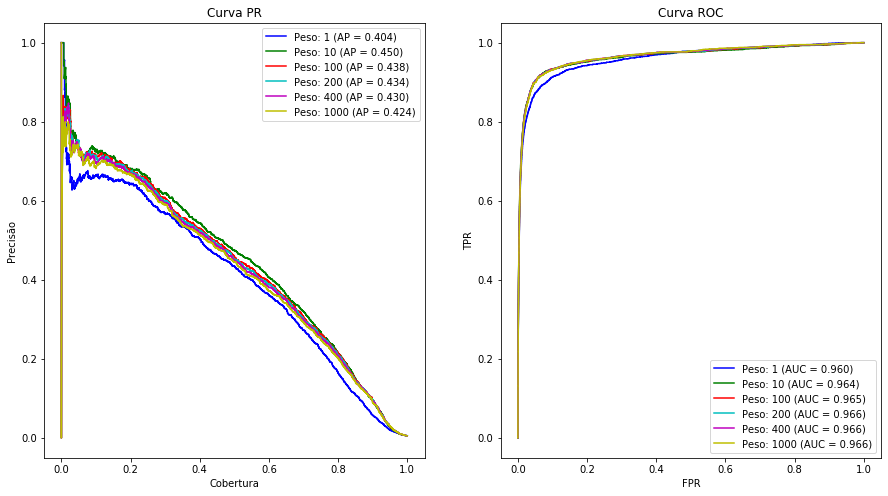

In [55]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Cobertura')
ax1.set_ylabel('Precisão')
ax1.set_title('Curva PR')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('FPR')
ax2.set_ylabel('TPR')
ax2.set_title('Curva ROC')

#[1,10,50,100,1000]
for w,k in zip([1, 10, 100, 200, 400, 1000],'bgrcmykw'):
    
    print('---Peso {} para a classe Morto---'.format(w))
    
    paramslg = {'class_weight' : {0 : 1, 1 : w}}
    model = LogisticRegression(**paramslg)
    #class_weight={0:1,1:2}
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)    

    p,r,_ = precision_recall_curve(y_test, y_prob[:,1])
    tpr,fpr,_ = roc_curve(y_test, y_prob[:,1])          
    
    auc = metrics.roc_auc_score(y_test, y_prob[:,1])
    average_precision = average_precision_score(y_test, y_prob[:,1])
    
    generate_performance_stats(y_test, y_pred)
    
    ax1.plot(r,p,c=k,label='Peso: ' + str(w) + ' (AP = %0.3f)' % (average_precision))
    ax2.plot(tpr,fpr,c=k,label='Peso: ' + str(w) + ' (AUC = %0.3f)' % (auc))
    
ax1.legend(loc='upper right')    
ax2.legend(loc='lower right')

dst = "../out/"
if os.path.isdir(dst) == False:
    os.makedirs(dst)
dst = dst + "/lr_prec_rec_roc_curve_imbalanced.pdf"
plt.savefig(dst, bbox_inches = 'tight')

plt.show()

### Uso da abordagem SHAP para explicar o resultado da predição dos modelos de aprendizado de máquina


In [3]:

shap.initjs()

In [4]:
X_train, X_test = train_test_split(df, test_size=0.30, random_state=13)

#X_train.rename(columns=colNamesEng, inplace=True)
y_train = X_train['morte_menor_28d'].values
X_train = X_train.drop(['morte_menor_28d', 'id'], axis=1)

In [8]:
paramsxgb = {'subsample': 1.0, 'min_child_weight': 5, 'max_depth': 2, 'gamma': 0.5,
             'colsample_bytree': 0.5, 'scale_pos_weight': 400}
xgb_model_shap = XGBClassifier(**paramsxgb)
xgb_model_shap.fit(X_train, y_train)

booster = xgb_model_shap.get_booster()
model2 = booster.save_raw()[4:]
booster.save_raw = lambda: model2

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(booster)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [9]:
shap_values = explainer.shap_values(X_train)
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_train.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=True)

In [12]:
def plot_myshap(importance_df,shap_sum):
    
    num_cols = importance_df.shape[0]    
    x = np.zeros(num_cols)
    y = range(num_cols)
    maxx = 0
    for i in range(num_cols):        
        x[i] = (importance_df.iloc[i,1]/np.sum(shap_sum))
        if (importance_df.iloc[i,1]/np.sum(shap_sum)) > maxx:
            maxx = float((importance_df.iloc[i,1]/np.sum(shap_sum)))

    fig = plt.figure(figsize=(10,8))
    c1 = 'm'
    c2 = 'c'
    my_colors = ''.join(1*[c2] + 2*[c2] + 1*[c2] + 1*[c2] + 1*[c2] + 12*[c2] + 1*[c2] + 2*[c2] + 2*[c2])
    #my_colors = ''.join(1*[c1] + 2*[c2] + 1*[c1] + 1*[c2] + 1*[c1] + 12*[c2] + 1*[c1] + 2*[c2] + 2*[c1])
    
    
    barlist = plt.barh(y, x, align='center',color=my_colors,edgecolor='black')        
    plt.yticks(range(num_cols),importance_df['column_name'],fontsize= 12)
    
    xlabels = []    
    for i in np.arange(0,((maxx*100)+1),2):
        tt = str(i) + "%"
        xlabels.append(tt)
        
    plt.xticks(np.arange(0,maxx,0.02),xlabels, fontsize=12)
    plt.xlabel('Porcentagem da importância', size=12)
    plt.title('Importância de cada variável no resultado final da classificação', size=12)

    plt.savefig('../out/shapvalues.png', bbox_inches = 'tight')

    plt.show()

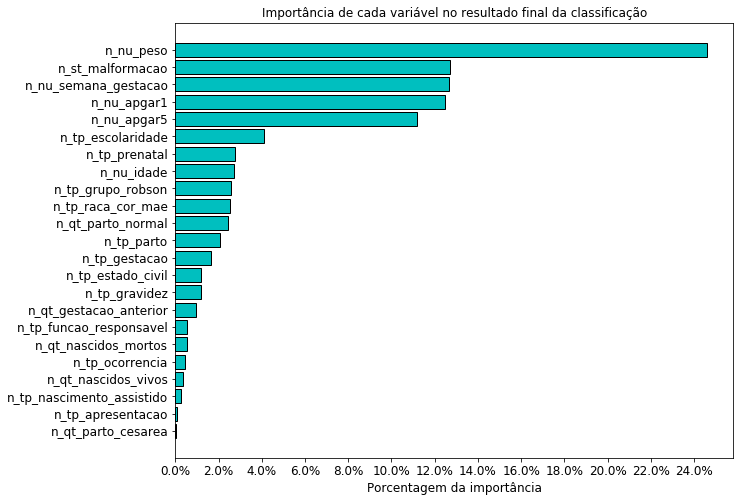

In [13]:
plot_myshap(importance_df,shap_sum)